In [3]:
import pandas as pd
import numpy as np
import os

INPUT_FILE_PATH = 'filtered_ohnologs_7497_basemean150.csv'
OUTPUT_DIR = 'expression_bias_categories_csv'


LOG2FC_LSOM_COL = 'log2FoldChange_S11_Lsom'
PADJ_LSOM_COL = 'padj_S11_Lsom'

LOG2FC_PHATCH_COL = 'log2FoldChange_S12_Prehatch' 
PADJ_PHATCH_COL = 'padj_S12_Prehatch'       


LOG2FC_THRESHOLD = 0.58 
PADJ_THRESHOLD = 0.05    


print(f"--- Step 2: Loading Data ---")


if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"Created output directory: {OUTPUT_DIR}")

try:
    df = pd.read_csv(INPUT_FILE_PATH)
    print(f"Successfully loaded {len(df)} pairs from '{INPUT_FILE_PATH}'\n")
except FileNotFoundError:
    print(f"ERROR: The input file '{INPUT_FILE_PATH}' was not found.")
    print("Please ensure the file from the previous step is in the same directory.")
    exit() 


def get_bias_category(df, log2fc_col, padj_col):
    """
    Applies Log2FC and padj thresholds to classify ohnolog pairs.
    Returns a pandas Series with the classification: 'SubgA_dominant', 'SubgB_dominant', or 'Balanced'.
    """
    is_significant = (df[padj_col] < PADJ_THRESHOLD) & (df[log2fc_col].abs() >= LOG2FC_THRESHOLD)

    conditions = [
        is_significant & (df[log2fc_col] > 0),  
        is_significant & (df[log2fc_col] < 0)   
    ]
    choices = ['SubgA_dominant', 'SubgB_dominant']

    return np.select(conditions, choices, default='Balanced')

print("--- Step 3: Categorizing Expression Bias for LSom and PHatch Stages ---")
print(f"Using thresholds: |Log2FC| >= {LOG2FC_THRESHOLD} AND padj < {PADJ_THRESHOLD}")

required_cols = [LOG2FC_LSOM_COL, PADJ_LSOM_COL, LOG2FC_PHATCH_COL, PADJ_PHATCH_COL]
missing_cols = [col for col in required_cols if col not in df.columns]

if missing_cols:
    print(f"\nERROR: The following required columns were not found in your CSV file: {missing_cols}")
    print("Please update the column name variables in the 'SETUP' section of the script.")
    exit()

df['Bias_Category_LSom'] = get_bias_category(df, LOG2FC_LSOM_COL, PADJ_LSOM_COL)
df['Bias_Category_PHatch'] = get_bias_category(df, LOG2FC_PHATCH_COL, PADJ_PHATCH_COL)

print("Categorization complete. Final counts:\n")
print("--- Late Somite (LSom) Counts ---")
print(df['Bias_Category_LSom'].value_counts())
print("\n--- PreHatch (PHatch) Counts ---")
print(df['Bias_Category_PHatch'].value_counts())


print(f"\n--- Step 4: Exporting 6 Categories to Separate CSV Files in '{OUTPUT_DIR}' ---")
stages = {'LSom': 'Bias_Category_LSom', 'PHatch': 'Bias_Category_PHatch'}
categories = ['SubgA_dominant', 'SubgB_dominant', 'Balanced']

for stage_name, category_col in stages.items():
    for category_name in categories:
    
        df_slice = df[df[category_col] == category_name]
        
        output_filename = f"{category_name}_{stage_name}.csv"
        output_path = os.path.join(OUTPUT_DIR, output_filename)
        
        df_slice.to_csv(output_path, index=False)
        
        print(f"Saved {len(df_slice)} pairs to '{output_path}'")

print("\n--- All steps completed successfully. ---")


--- Step 2: Loading Data ---
Created output directory: expression_bias_categories_csv
Successfully loaded 7497 pairs from 'filtered_ohnologs_7497_basemean150.csv'

--- Step 3: Categorizing Expression Bias for LSom and PHatch Stages ---
Using thresholds: |Log2FC| >= 0.58 AND padj < 0.05
Categorization complete. Final counts:

--- Late Somite (LSom) Counts ---
Bias_Category_LSom
Balanced          3677
SubgB_dominant    1969
SubgA_dominant    1851
Name: count, dtype: int64

--- PreHatch (PHatch) Counts ---
Bias_Category_PHatch
Balanced          4004
SubgB_dominant    1803
SubgA_dominant    1690
Name: count, dtype: int64

--- Step 4: Exporting 6 Categories to Separate CSV Files in 'expression_bias_categories_csv' ---
Saved 1851 pairs to 'expression_bias_categories_csv/SubgA_dominant_LSom.csv'
Saved 1969 pairs to 'expression_bias_categories_csv/SubgB_dominant_LSom.csv'
Saved 3677 pairs to 'expression_bias_categories_csv/Balanced_LSom.csv'
Saved 1690 pairs to 'expression_bias_categories_csv/

In [1]:
import pandas as pd

MAPPING_FILE_PATH = 'Zebrafish_mapping.tsv' 


def inspect_mapping_file(filepath):
    """
    Loads a mapping file and prints a detailed report about its structure and content.
    """
    print(f"--- Inspecting File: {filepath} ---\n")

    try:
        if filepath.endswith('.csv'):
            df = pd.read_csv(filepath)
        elif filepath.endswith('.xlsx'):
            df = pd.read_excel(filepath)
        elif filepath.endswith('.txt') or filepath.endswith('.tsv'):
            df = pd.read_csv(filepath, sep='\t')
        else:
            print(f"Error: Unknown file type for '{filepath}'. Please use .csv, .xlsx, or .txt/.tsv")
            return
            
    except FileNotFoundError:
        print(f"CRITICAL ERROR: The file '{filepath}' was not found.")
        print("Please make sure the file is in the same directory as this script and the filename is correct.")
        return
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")
        return

    print("1. File Shape")
    print(f"   - Number of rows (mappings): {df.shape[0]}")
    print(f"   - Number of columns: {df.shape[1]}\n")

    print("2. Column Headers")
    print(f"   - The column names are: {df.columns.tolist()}\n")

    print("3. Data Preview (First 5 Rows)")
    print("---------------------------------")
    print(df.head(5).to_string())
    print("---------------------------------\n")

    print("4. Missing Values")
    print("   - Count of empty/NaN cells in each column:")
    print(df.isnull().sum().to_string())
    print("\n")

    print("5. Unique ID Summary (Heuristic)")
    inspected_cols = []
    for col in df.columns:
        if 'gene' in col.lower() or 'id' in col.lower() or 'symbol' in col.lower() or 'name' in col.lower():
            inspected_cols.append(col)
            num_unique = df[col].nunique()
            print(f"   - Column '{col}':")
            print(f"     - Number of unique identifiers: {num_unique}")

    if not inspected_cols:
        print("   - Could not automatically identify likely ID columns based on name.")
        print("     (This is okay, the manual inspection of the preview above is most important.)")
        
    print("\n--- Inspection Complete ---")

if __name__ == "__main__":
    inspect_mapping_file(MAPPING_FILE_PATH)



--- Inspecting File: Zebrafish_mapping.tsv ---

1. File Shape
   - Number of rows (mappings): 15653
   - Number of columns: 6

2. Column Headers
   - The column names are: ['Gene stable ID', 'Common carp gene name', 'Gene name', 'Common carp gene stable ID', 'Common carp orthology confidence [0 low, 1 high]', 'Common carp homology type']

3. Data Preview (First 5 Rows)
---------------------------------
       Gene stable ID Common carp gene name Gene name Common carp gene stable ID  Common carp orthology confidence [0 low, 1 high] Common carp homology type
0  ENSDARG00000063344               fam162a   fam162a         ENSCCRG00000055380                                               1.0         ortholog_one2many
1  ENSDARG00000063344               fam162a   fam162a         ENSCCRG00000050627                                               1.0         ortholog_one2many
2  ENSDARG00000036008                  caly      caly         ENSCCRG00000037916                                           

In [7]:
import pandas as pd
import os

# --- 1. SETUP: PLEASE VERIFY THESE VARIABLES ---

# --- File Paths ---
# The TSV file with your zebrafish mappings.
MAPPING_FILE_PATH = 'Zebrafish_mapping.tsv'

# The directory where your 6 category CSV files are located.
CATEGORIES_DIR = 'expression_bias_categories_csv'

# A new directory where we will save the final 6 lists of zebrafish IDs.
OUTPUT_DIR = 'zebrafish_gene_lists'

# --- Column Names ---
# Column names from your CATEGORY files (e.g., SubgA_dominant_LSom.csv)
CARP_ID_A_COL = 'geneID_sgA'
CARP_ID_B_COL = 'geneID_sgB'

# Column names from your MAPPING file
MAPPING_CARP_ID_COL = 'Common carp gene stable ID'
MAPPING_ZEBRAFISH_ID_COL = 'Gene stable ID'
MAPPING_CONFIDENCE_COL = 'Common carp orthology confidence [0 low, 1 high]'


# --- 2. LOAD AND PREPARE THE MAPPING DICTIONARY ---
print("--- Step 2: Loading and Preparing Zebrafish Mapping Data ---")

# Create the output directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"Created output directory: '{OUTPUT_DIR}'")

try:
    df_map = pd.read_csv(MAPPING_FILE_PATH, sep='\t')
    print(f"Successfully loaded {len(df_map)} rows from '{MAPPING_FILE_PATH}'")

    # Filter for high-confidence mappings only
    df_map_high_conf = df_map[df_map[MAPPING_CONFIDENCE_COL] == 1.0]
    print(f"Filtered to {len(df_map_high_conf)} high-confidence (1.0) mappings.")

    # Create a simple and fast lookup dictionary: {carp_id: zebrafish_id}
    # This is much faster than searching a DataFrame repeatedly.
    zebrafish_lookup = pd.Series(
        df_map_high_conf[MAPPING_ZEBRAFISH_ID_COL].values,
        index=df_map_high_conf[MAPPING_CARP_ID_COL]
    ).to_dict()
    print("Created mapping dictionary for fast lookups.\n")

except FileNotFoundError:
    print(f"CRITICAL ERROR: The mapping file '{MAPPING_FILE_PATH}' was not found.")
    exit()
except KeyError as e:
    print(f"CRITICAL ERROR: A required column was not found in the mapping file: {e}")
    print("Please check the MAPPING_ column name variables in the script.")
    exit()


# --- 3. PROCESS EACH CATEGORY FILE AND MAP TO ZEBRAFISH IDS ---
print(f"--- Step 3: Processing 6 Category Files from '{CATEGORIES_DIR}' ---")

if not os.path.exists(CATEGORIES_DIR):
    print(f"CRITICAL ERROR: The directory '{CATEGORIES_DIR}' was not found.")
    exit()
    
# Get the list of the 6 CSV files to process
try:
    category_files = [f for f in os.listdir(CATEGORIES_DIR) if f.endswith('.csv')]
    if not category_files:
        raise FileNotFoundError
except FileNotFoundError:
     print(f"CRITICAL ERROR: No .csv files found in '{CATEGORIES_DIR}'.")
     exit()

# Loop through each of the 6 files
for filename in category_files:
    filepath = os.path.join(CATEGORIES_DIR, filename)
    print(f"\nProcessing '{filename}'...")
    
    try:
        df_category = pd.read_csv(filepath)
    except Exception as e:
        print(f"  Could not read file. Error: {e}")
        continue

    # A set is used to automatically store only unique zebrafish IDs
    unique_zebrafish_ids = set()
    mapped_pairs_count = 0
    unmapped_carp_ids = set()

    # Iterate over each ohnolog pair (each row) in the file
    for index, row in df_category.iterrows():
        carp_id_a = row.get(CARP_ID_A_COL)
        carp_id_b = row.get(CARP_ID_B_COL)
        
        found_mapping_for_pair = False

        # Look up the ID for subgenome A
        if pd.notna(carp_id_a) and carp_id_a in zebrafish_lookup:
            unique_zebrafish_ids.add(zebrafish_lookup[carp_id_a])
            found_mapping_for_pair = True
        elif pd.notna(carp_id_a):
            unmapped_carp_ids.add(carp_id_a)
            
        # Look up the ID for subgenome B
        if pd.notna(carp_id_b) and carp_id_b in zebrafish_lookup:
            unique_zebrafish_ids.add(zebrafish_lookup[carp_id_b])
            found_mapping_for_pair = True
        elif pd.notna(carp_id_b):
            unmapped_carp_ids.add(carp_id_b)

        if found_mapping_for_pair:
            mapped_pairs_count += 1
            
    # --- Reporting and Saving ---
    print(f"  - Found {len(unique_zebrafish_ids)} unique zebrafish IDs for this category.")
    print(f"  - Mapped at least one ohnolog for {mapped_pairs_count} out of {len(df_category)} pairs.")
    if len(unmapped_carp_ids) > 0:
        print(f"  - Note: Could not find mappings for {len(unmapped_carp_ids)} unique carp IDs.")

    # Define the output file path for the list of zebrafish IDs
    output_filename_txt = filename.replace('.csv', '_zebrafish_IDs.txt')
    output_path = os.path.join(OUTPUT_DIR, output_filename_txt)

    # Write the unique IDs to the text file
    with open(output_path, 'w') as f:
        for zf_id in sorted(list(unique_zebrafish_ids)): # Sorting is good practice
            f.write(f"{zf_id}\n")
            
    print(f"  - SUCCESS: Saved list to '{output_path}'")

print("\n--- All steps completed successfully. ---")


--- Step 2: Loading and Preparing Zebrafish Mapping Data ---
Created output directory: 'zebrafish_gene_lists'
Successfully loaded 15653 rows from 'Zebrafish_mapping.tsv'
Filtered to 13908 high-confidence (1.0) mappings.
Created mapping dictionary for fast lookups.

--- Step 3: Processing 6 Category Files from 'expression_bias_categories_csv' ---

Processing 'Balanced_PHatch.csv'...
  - Found 2980 unique zebrafish IDs for this category.
  - Mapped at least one ohnolog for 2980 out of 4004 pairs.
  - Note: Could not find mappings for 2082 unique carp IDs.
  - SUCCESS: Saved list to 'zebrafish_gene_lists/Balanced_PHatch_zebrafish_IDs.txt'

Processing 'SubgA_dominant_LSom.csv'...
  - Found 1364 unique zebrafish IDs for this category.
  - Mapped at least one ohnolog for 1364 out of 1851 pairs.
  - Note: Could not find mappings for 984 unique carp IDs.
  - SUCCESS: Saved list to 'zebrafish_gene_lists/SubgA_dominant_LSom_zebrafish_IDs.txt'

Processing 'SubgB_dominant_LSom.csv'...
  - Found 14

In [9]:
import pandas as pd

OHNOLOG_SET_PATH = 'filtered_ohnologs_7497_basemean150.csv' 

MAPPING_FILE_PATH = 'Zebrafish_mapping.tsv'

CARP_ID_A_COL = 'geneID_sgA'
CARP_ID_B_COL = 'geneID_sgB'

MAPPING_CARP_ID_COL = 'Common carp gene stable ID'
MAPPING_CONFIDENCE_COL = 'Common carp orthology confidence [0 low, 1 high]'


print("--- Step 1: Calculating total unique carp gene IDs from your dataset ---")

try:
    df_ohnologs = pd.read_csv(OHNOLOG_SET_PATH)
    
    ids_a = set(df_ohnologs[CARP_ID_A_COL].dropna())
    ids_b = set(df_ohnologs[CARP_ID_B_COL].dropna())
    
    total_unique_carp_ids = ids_a.union(ids_b)
    
    num_total_unique_carp_ids = len(total_unique_carp_ids)
    print(f"Found {num_total_unique_carp_ids} total unique carp stable IDs in '{OHNOLOG_SET_PATH}'.\n")

except FileNotFoundError:
     print(f"CRITICAL ERROR: The main ohnolog file '{OHNOLOG_SET_PATH}' was not found.")
     exit()
except KeyError as e:
    print(f"CRITICAL ERROR: A required column was not found in the ohnolog file: {e}")
    exit()

print("--- Step 2: Calculating which of those IDs have a high-confidence mapping ---")

try:
    df_map = pd.read_csv(MAPPING_FILE_PATH, sep='\t')
    
    df_map_high_conf = df_map[df_map[MAPPING_CONFIDENCE_COL] == 1.0]
    
    mappable_carp_ids = set(df_map_high_conf[MAPPING_CARP_ID_COL].dropna())
    
    print(f"Found {len(mappable_carp_ids)} carp IDs with high-confidence mappings in '{MAPPING_FILE_PATH}'.\n")

except FileNotFoundError:
    print(f"CRITICAL ERROR: The mapping file '{MAPPING_FILE_PATH}' was not found.")
    exit()
except KeyError as e:
    print(f"CRITICAL ERROR: A required column was not found in the mapping file: {e}")
    exit()

print("--- Step 3: Calculating Final Mapping Percentage ---")

successfully_mapped_ids = total_unique_carp_ids.intersection(mappable_carp_ids)
num_successfully_mapped = len(successfully_mapped_ids)

if num_total_unique_carp_ids > 0:
    mapping_percentage = (num_successfully_mapped / num_total_unique_carp_ids) * 100
else:
    mapping_percentage = 0

print(f"Total unique carp IDs in your dataset: {num_total_unique_carp_ids}")
print(f"Number of those IDs successfully mapped to a zebrafish ortholog: {num_successfully_mapped}")
print("\n----------------------------------------------------")
print(f"Ortholog Mapping Percentage: {mapping_percentage:.2f}%")
print("----------------------------------------------------")



--- Step 1: Calculating total unique carp gene IDs from your dataset ---
Found 14994 total unique carp stable IDs in 'filtered_ohnologs_7497_basemean150.csv'.

--- Step 2: Calculating which of those IDs have a high-confidence mapping ---
Found 13881 carp IDs with high-confidence mappings in 'Zebrafish_mapping.tsv'.

--- Step 3: Calculating Final Mapping Percentage ---
Total unique carp IDs in your dataset: 14994
Number of those IDs successfully mapped to a zebrafish ortholog: 11101

----------------------------------------------------
Ortholog Mapping Percentage: 74.04%
----------------------------------------------------


In [3]:
import pandas as pd
import os


OHNOLOG_SET_PATH = 'filtered_ohnologs_7497_basemean150.csv' 

MAPPING_FILE_PATH = 'Zebrafish_mapping.tsv'

OUTPUT_FILE = 'background_universe_zebrafish_IDs.txt'


CARP_ID_A_COL = 'geneID_sgA'
CARP_ID_B_COL = 'geneID_sgB'


MAPPING_CARP_ID_COL = 'Common carp gene stable ID'
MAPPING_ZEBRAFISH_ID_COL = 'Gene stable ID'
MAPPING_CONFIDENCE_COL = 'Common carp orthology confidence [0 low, 1 high]'


print("--- Step 2: Loading and Preparing Zebrafish Mapping Data ---")

try:
    df_map = pd.read_csv(MAPPING_FILE_PATH, sep='\t')
    
    df_map_high_conf = df_map[df_map[MAPPING_CONFIDENCE_COL] == 1.0]
    zebrafish_lookup = pd.Series(
        df_map_high_conf[MAPPING_ZEBRAFISH_ID_COL].values,
        index=df_map_high_conf[MAPPING_CARP_ID_COL]
    ).to_dict()
    print(f"Loaded {len(zebrafish_lookup)} high-confidence mappings.\n")

except FileNotFoundError:
    print(f"CRITICAL ERROR: The mapping file '{MAPPING_FILE_PATH}' was not found.")
    exit()
except KeyError as e:
    print(f"CRITICAL ERROR: A required column was not found in the mapping file: {e}")
    exit()

print(f"--- Step 3: Creating Background Universe from '{OHNOLOG_SET_PATH}' ---")

try:
    df_ohnologs = pd.read_csv(OHNOLOG_SET_PATH)
except FileNotFoundError:
     print(f"CRITICAL ERROR: The main ohnolog file '{OHNOLOG_SET_PATH}' was not found.")
     exit()

unique_background_ids = set()

for index, row in df_ohnologs.iterrows():
    carp_id_a = row.get(CARP_ID_A_COL)
    carp_id_b = row.get(CARP_ID_B_COL)
    
    if pd.notna(carp_id_a) and carp_id_a in zebrafish_lookup:
        unique_background_ids.add(zebrafish_lookup[carp_id_a])

    if pd.notna(carp_id_b) and carp_id_b in zebrafish_lookup:
        unique_background_ids.add(zebrafish_lookup[carp_id_b])
        
print(f"Found {len(unique_background_ids)} unique zebrafish IDs to form the background universe.")

with open(OUTPUT_FILE, 'w') as f:
    for zf_id in sorted(list(unique_background_ids)):
        f.write(f"{zf_id}\n")
        
print(f"SUCCESS: Saved the background universe list to '{OUTPUT_FILE}'")
print("\n--- All data preparation is now complete---")

--- Step 2: Loading and Preparing Zebrafish Mapping Data ---
Loaded 13881 high-confidence mappings.

--- Step 3: Creating Background Universe from 'filtered_ohnologs_7497_basemean150.csv' ---
Found 5581 unique zebrafish IDs to form the background universe.
SUCCESS: Saved the background universe list to 'background_universe_zebrafish_IDs.txt'

--- All data preparation is now complete---


In [1]:
import pandas as pd
import numpy as np

INPUT_FILE_PATH = 'filtered_ohnologs_7497_basemean150.csv'

LOG2FC_LSOM_COL = 'log2FoldChange_S11_Lsom'
PADJ_LSOM_COL = 'padj_S11_Lsom'

LOG2FC_PHATCH_COL = 'log2FoldChange_S12_Prehatch' 
PADJ_PHATCH_COL = 'padj_S12_Prehatch'       


PADJ_THRESHOLD = 0.05

MODERATE_THRESHOLD = 0.58 

STRONG_THRESHOLD = 2.0   

EXTREME_THRESHOLD = 3.0  


print(f"--- Loading data from '{INPUT_FILE_PATH}' ---")
try:
    df = pd.read_csv(INPUT_FILE_PATH)
    print(f"Successfully loaded {len(df)} pairs.\n")
except FileNotFoundError:
    print(f"CRITICAL ERROR: The input file '{INPUT_FILE_PATH}' was not found.")
    exit()



def get_stratified_bias(df, log2fc_col, padj_col):
    """
    Applies stratified thresholds to classify pairs into 7 categories.
    """
    is_significant = df[padj_col] < PADJ_THRESHOLD
    

    abs_log2fc = df[log2fc_col].abs()

    conditions = [
        (~is_significant) | (abs_log2fc < MODERATE_THRESHOLD),
        (is_significant) & (df[log2fc_col] >= EXTREME_THRESHOLD),
        (is_significant) & (df[log2fc_col] <= -EXTREME_THRESHOLD),
        (is_significant) & (df[log2fc_col] >= STRONG_THRESHOLD),
        (is_significant) & (df[log2fc_col] <= -STRONG_THRESHOLD),
        (is_significant) & (df[log2fc_col] >= MODERATE_THRESHOLD),
        (is_significant) & (df[log2fc_col] <= -MODERATE_THRESHOLD)
    ]
    
    choices = [
        'No_Significant_Bias',
        'Extreme_SubgA_Dom',
        'Extreme_SubgB_Dom',
        'Strong_SubgA_Dom',
        'Strong_SubgB_Dom',
        'Moderate_SubgA_Dom',
        'Moderate_SubgB_Dom'
    ]
    
   
    return np.select(conditions, choices, default='Uncategorized')



required_cols = [LOG2FC_LSOM_COL, PADJ_LSOM_COL, LOG2FC_PHATCH_COL, PADJ_PHATCH_COL]
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print(f"\nERROR: The following required columns were not found in your CSV file: {missing_cols}")
    print("Please update the column name variables in the 'SETUP' section of the script.")
    exit()

df['Bias_Magnitude_LSom'] = get_stratified_bias(df, LOG2FC_LSOM_COL, PADJ_LSOM_COL)
df['Bias_Magnitude_Prehatch'] = get_stratified_bias(df, LOG2FC_PHATCH_COL, PADJ_PHATCH_COL)

print("--- Counts of Ohnolog Pairs by Bias Magnitude (Late Somite) ---")
print(df['Bias_Magnitude_LSom'].value_counts().to_string())

print("\n\n--- Counts of Ohnolog Pairs by Bias Magnitude (PreHatch Stage) ---")
print(df['Bias_Magnitude_Prehatch'].value_counts().to_string())


--- Loading data from 'filtered_ohnologs_7497_basemean150.csv' ---
Successfully loaded 7497 pairs.

--- Counts of Ohnolog Pairs by Bias Magnitude (Late Somite) ---
Bias_Magnitude_LSom
No_Significant_Bias    3677
Moderate_SubgA_Dom     1333
Moderate_SubgB_Dom     1303
Extreme_SubgB_Dom       386
Strong_SubgB_Dom        280
Extreme_SubgA_Dom       270
Strong_SubgA_Dom        248


--- Counts of Ohnolog Pairs by Bias Magnitude (PreHatch Stage) ---
Bias_Magnitude_Prehatch
No_Significant_Bias    4004
Moderate_SubgA_Dom     1281
Moderate_SubgB_Dom     1217
Extreme_SubgB_Dom       337
Strong_SubgB_Dom        249
Extreme_SubgA_Dom       221
Strong_SubgA_Dom        188


In [3]:
import pandas as pd
import numpy as np
import os


INPUT_FILE_PATH = 'filtered_ohnologs_7497_basemean150.csv'
OUTPUT_DIR = 'stratified_expression_bias_lists'

LOG2FC_LSOM_COL = 'log2FoldChange_S11_Lsom'
PADJ_LSOM_COL = 'padj_S11_Lsom'

LOG2FC_PHATCH_COL = 'log2FoldChange_S12_Prehatch' 
PADJ_PHATCH_COL = 'padj_S12_Prehatch'       


PADJ_THRESHOLD = 0.05
MODERATE_THRESHOLD = 0.58 
STRONG_THRESHOLD = 2.0   
EXTREME_THRESHOLD = 3.0  

print(f"--- Step 2: Loading Data and Preparing for Export ---")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"Created output directory: '{OUTPUT_DIR}'")

try:
    df = pd.read_csv(INPUT_FILE_PATH)
    print(f"Successfully loaded {len(df)} pairs from '{INPUT_FILE_PATH}'.\n")
except FileNotFoundError:
    print(f"CRITICAL ERROR: The input file '{INPUT_FILE_PATH}' was not found.")
    exit()

def get_stratified_bias(df, log2fc_col, padj_col):
    """Applies stratified thresholds to classify pairs into 7 categories."""
    is_significant = df[padj_col] < PADJ_THRESHOLD
    abs_log2fc = df[log2fc_col].abs()
    
    conditions = [
        (~is_significant) | (abs_log2fc < MODERATE_THRESHOLD),
        (is_significant) & (df[log2fc_col] >= EXTREME_THRESHOLD),
        (is_significant) & (df[log2fc_col] <= -EXTREME_THRESHOLD),
        (is_significant) & (df[log2fc_col] >= STRONG_THRESHOLD),
        (is_significant) & (df[log2fc_col] <= -STRONG_THRESHOLD),
        (is_significant) & (df[log2fc_col] >= MODERATE_THRESHOLD),
        (is_significant) & (df[log2fc_col] <= -MODERATE_THRESHOLD)
    ]
    choices = [
        'No_Significant_Bias', 'Extreme_SubgA_Dom', 'Extreme_SubgB_Dom',
        'Strong_SubgA_Dom', 'Strong_SubgB_Dom', 'Moderate_SubgA_Dom', 'Moderate_SubgB_Dom'
    ]
    return np.select(conditions, choices, default='Uncategorized')

print("--- Step 4: Applying Stratification and Exporting Lists ---")

required_cols = [LOG2FC_LSOM_COL, PADJ_LSOM_COL, LOG2FC_PHATCH_COL, PADJ_PHATCH_COL]
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print(f"\nERROR: Required columns not found: {missing_cols}. Please update SETUP variables.")
    exit()

df['Bias_Magnitude_LSom'] = get_stratified_bias(df, LOG2FC_LSOM_COL, PADJ_LSOM_COL)
df['Bias_Magnitude_Prehatch'] = get_stratified_bias(df, LOG2FC_PHATCH_COL, PADJ_PHATCH_COL)


stages = {
    'LSom': 'Bias_Magnitude_LSom',
    'PHatch': 'Bias_Magnitude_Prehatch'
}

categories = [
    'Extreme_SubgA_Dom', 'Extreme_SubgB_Dom', 'Strong_SubgA_Dom', 'Strong_SubgB_Dom',
    'Moderate_SubgA_Dom', 'Moderate_SubgB_Dom', 'No_Significant_Bias'
]

for stage_name, category_col in stages.items():
    print(f"\nExporting lists for {stage_name} stage...")
    for category_name in categories:
        df_slice = df[df[category_col] == category_name]
        
        output_filename = f"{category_name}_{stage_name}.csv"
        output_path = os.path.join(OUTPUT_DIR, output_filename)
        
     
        df_slice.to_csv(output_path, index=False)
        
        print(f"  - Saved {len(df_slice)} pairs to '{output_path}'")

print("\n--- All 14 stratified lists have been successfully created. ---")

--- Step 2: Loading Data and Preparing for Export ---
Created output directory: 'stratified_expression_bias_lists'
Successfully loaded 7497 pairs from 'filtered_ohnologs_7497_basemean150.csv'.

--- Step 4: Applying Stratification and Exporting Lists ---

Exporting lists for LSom stage...
  - Saved 270 pairs to 'stratified_expression_bias_lists/Extreme_SubgA_Dom_LSom.csv'
  - Saved 386 pairs to 'stratified_expression_bias_lists/Extreme_SubgB_Dom_LSom.csv'
  - Saved 248 pairs to 'stratified_expression_bias_lists/Strong_SubgA_Dom_LSom.csv'
  - Saved 280 pairs to 'stratified_expression_bias_lists/Strong_SubgB_Dom_LSom.csv'
  - Saved 1333 pairs to 'stratified_expression_bias_lists/Moderate_SubgA_Dom_LSom.csv'
  - Saved 1303 pairs to 'stratified_expression_bias_lists/Moderate_SubgB_Dom_LSom.csv'
  - Saved 3677 pairs to 'stratified_expression_bias_lists/No_Significant_Bias_LSom.csv'

Exporting lists for PHatch stage...
  - Saved 221 pairs to 'stratified_expression_bias_lists/Extreme_SubgA_Dom

In [5]:
import pandas as pd
import os

MAPPING_FILE_PATH = 'Zebrafish_mapping.tsv'

CATEGORIES_DIR = 'stratified_expression_bias_lists'

OUTPUT_DIR = 'stratified_zebrafish_gene_lists'

CARP_ID_A_COL = 'geneID_sgA'
CARP_ID_B_COL = 'geneID_sgB'

MAPPING_CARP_ID_COL = 'Common carp gene stable ID'
MAPPING_ZEBRAFISH_ID_COL = 'Gene stable ID'
MAPPING_CONFIDENCE_COL = 'Common carp orthology confidence [0 low, 1 high]'


print("--- Step 2: Loading and Preparing Zebrafish Mapping Data ---")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"Created output directory: '{OUTPUT_DIR}'")

try:
    df_map = pd.read_csv(MAPPING_FILE_PATH, sep='\t')

    df_map_high_conf = df_map[df_map[MAPPING_CONFIDENCE_COL] == 1.0]

    zebrafish_lookup = pd.Series(
        df_map_high_conf[MAPPING_ZEBRAFISH_ID_COL].values,
        index=df_map_high_conf[MAPPING_CARP_ID_COL]
    ).to_dict()
    print(f"Loaded {len(zebrafish_lookup)} high-confidence mappings.\n")

except FileNotFoundError:
    print(f"CRITICAL ERROR: The mapping file '{MAPPING_FILE_PATH}' was not found.")
    exit()
except KeyError as e:
    print(f"CRITICAL ERROR: A required column was not found in the mapping file: {e}")
    exit()

print(f"--- Step 3: Processing 14 Stratified Files from '{CATEGORIES_DIR}' ---")

if not os.path.exists(CATEGORIES_DIR):
    print(f"CRITICAL ERROR: The directory '{CATEGORIES_DIR}' was not found.")
    exit()
    
try:
    category_files = [f for f in os.listdir(CATEGORIES_DIR) if f.endswith('.csv')]
    if not category_files:
        raise FileNotFoundError
except FileNotFoundError:
     print(f"CRITICAL ERROR: No .csv files found in '{CATEGORIES_DIR}'.")
     exit()

for filename in category_files:
    filepath = os.path.join(CATEGORIES_DIR, filename)
    print(f"\nProcessing '{filename}'...")
    
    try:
        df_category = pd.read_csv(filepath)
        if df_category.empty:
            print("  - This category is empty. Skipping.")
            continue
    except Exception as e:
        print(f"  Could not read file. Error: {e}")
        continue

    unique_zebrafish_ids = set()

    for index, row in df_category.iterrows():
        carp_id_a = row.get(CARP_ID_A_COL)
        carp_id_b = row.get(CARP_ID_B_COL)

        if pd.notna(carp_id_a) and carp_id_a in zebrafish_lookup:
            unique_zebrafish_ids.add(zebrafish_lookup[carp_id_a])
 
        if pd.notna(carp_id_b) and carp_id_b in zebrafish_lookup:
            unique_zebrafish_ids.add(zebrafish_lookup[carp_id_b])

    print(f"  - Found {len(unique_zebrafish_ids)} unique zebrafish IDs for this category.")

    output_filename_txt = filename.replace('.csv', '_zebrafish_IDs.txt')
    output_path = os.path.join(OUTPUT_DIR, output_filename_txt)

    with open(output_path, 'w') as f:
        for zf_id in sorted(list(unique_zebrafish_ids)): 
            f.write(f"{zf_id}\n")
            
    print(f"  - SUCCESS: Saved list to '{output_path}'")


--- Step 2: Loading and Preparing Zebrafish Mapping Data ---
Created output directory: 'stratified_zebrafish_gene_lists'
Loaded 13881 high-confidence mappings.

--- Step 3: Processing 14 Stratified Files from 'stratified_expression_bias_lists' ---

Processing 'Moderate_SubgA_Dom_LSom.csv'...
  - Found 989 unique zebrafish IDs for this category.
  - SUCCESS: Saved list to 'stratified_zebrafish_gene_lists/Moderate_SubgA_Dom_LSom_zebrafish_IDs.txt'

Processing 'Strong_SubgA_Dom_LSom.csv'...
  - Found 198 unique zebrafish IDs for this category.
  - SUCCESS: Saved list to 'stratified_zebrafish_gene_lists/Strong_SubgA_Dom_LSom_zebrafish_IDs.txt'

Processing 'Strong_SubgA_Dom_PHatch.csv'...
  - Found 141 unique zebrafish IDs for this category.
  - SUCCESS: Saved list to 'stratified_zebrafish_gene_lists/Strong_SubgA_Dom_PHatch_zebrafish_IDs.txt'

Processing 'Extreme_SubgA_Dom_LSom.csv'...
  - Found 177 unique zebrafish IDs for this category.
  - SUCCESS: Saved list to 'stratified_zebrafish_gen

--- Loading TF data for final faceted plot... ---
--- Generating final faceted bar chart... ---
--- Final plot saved successfully as 'final_tf_comparison_plot.png' ---


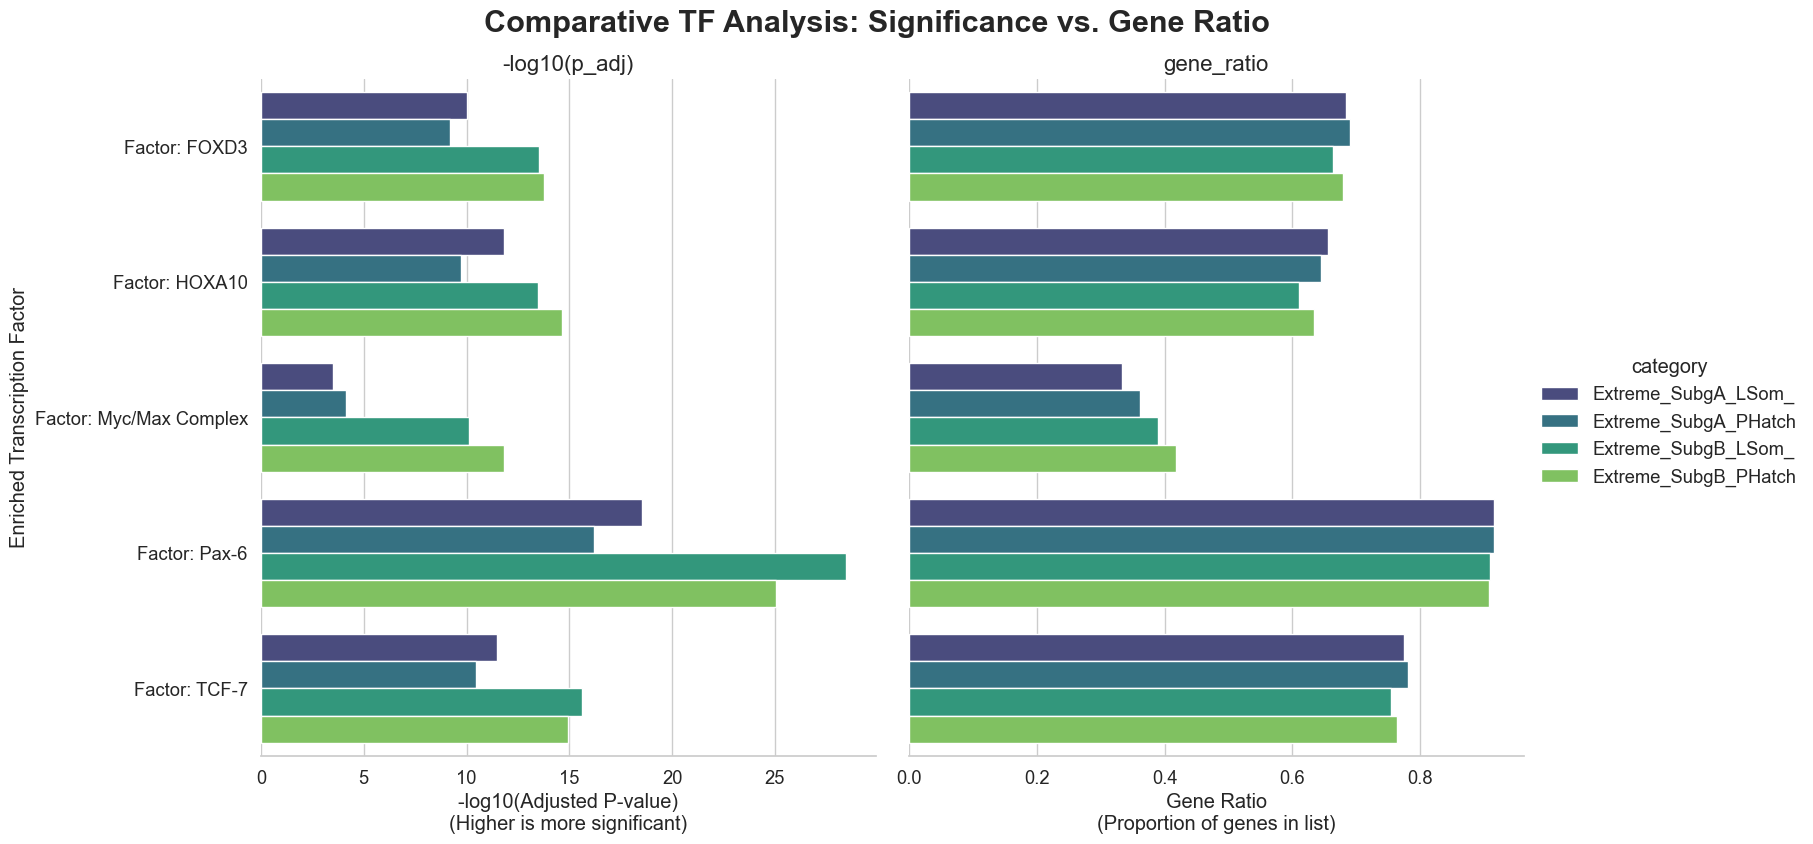

In [49]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


GPROFILER_RESULTS_DIR = 'gprofiler_results'
FILES_TO_PLOT = [
    'Extreme_SubgA_Dom_LSom__intersections.csv',
    'Extreme_SubgA_Dom_PHatch_intersections.csv',
    'Extreme_SubgB_Dom_LSom__intersections.csv',
    'Extreme_SubgB_Dom_PHatch_intersections.csv',
]

KEY_TF_SUBSTRINGS = [
    'c-Myc', 'Max', 'Pax-6', 'TCF-7', 'HOXA10', 'FOXD3'
]

TERMS_TO_EXCLUDE = ['Transfac']

def load_and_process_for_plot(directory, files_to_plot):
    all_results = []
    for filename in files_to_plot:
        category_name = filename.replace('gProfiler_', '').replace('.csv', '') \
                                .replace('_Dom', '').replace('_intersections', '')
        filepath = os.path.join(directory, filename)
        if not os.path.exists(filepath): continue
        df = pd.read_csv(filepath, comment='#')
        df_tf = df[df['source'] == 'TF'].copy()
        
        df_tf['gene_ratio'] = df_tf['intersection_size'] / df_tf['query_size']
        df_tf['adjusted_p_value'] = df_tf['adjusted_p_value'].replace(0, 1e-323)
        df_tf['-log10(p_adj)'] = -np.log10(df_tf['adjusted_p_value'])
        df_tf['category'] = category_name
        all_results.append(df_tf)
        
    if not all_results: return pd.DataFrame()
    return pd.concat(all_results, ignore_index=True)

print("--- Loading TF data for final faceted plot... ---")
df_all_tf_results = load_and_process_for_plot(GPROFILER_RESULTS_DIR, FILES_TO_PLOT)

if not df_all_tf_results.empty:
    df_filtered = df_all_tf_results[~df_all_tf_results['term_name'].isin(TERMS_TO_EXCLUDE)]
    tf_mask = df_filtered['term_name'].str.contains('|'.join(KEY_TF_SUBSTRINGS), na=False)
    df_plot_data = df_filtered[tf_mask].copy()

    def simplify_tf_name(name):
        name_lower = name.lower()
        if 'myc' in name_lower or 'max' in name_lower: return 'Factor: Myc/Max Complex'
        for prefix in KEY_TF_SUBSTRINGS:
            if prefix in name:
                all_variants = [term for term in df_plot_data['term_name'] if prefix in term]
                shortest_variant = min(all_variants, key=len)
                return shortest_variant.split(';')[0]
        return name

    df_plot_data['term_name'] = df_plot_data['term_name'].apply(simplify_tf_name)
    df_plot_data_agg = df_plot_data.groupby(['term_name', 'category']).agg(
        **{'-log10(p_adj)': ('-log10(p_adj)', 'max'), 'gene_ratio': ('gene_ratio', 'max')}
    ).reset_index()

if 'df_plot_data_agg' in locals() and not df_plot_data_agg.empty:
    print("--- Generating final faceted bar chart... ---")
    
    category_order = [cat.replace('gProfiler_', '').replace('.csv', '').replace('_Dom', '').replace('_intersections', '') for cat in FILES_TO_PLOT]
  
    df_melted = pd.melt(df_plot_data_agg, id_vars=['term_name', 'category'], value_vars=['-log10(p_adj)', 'gene_ratio'],
                        var_name='Metric', value_name='Value')

    g = sns.catplot(
        data=df_melted,
        x='Value',
        y='term_name',
        hue='category',
        col='Metric',
        kind='bar',
        height=8,
        aspect=1,
        palette='viridis',
        sharex=False
    )

    g.fig.suptitle('Comparative TF Analysis: Significance vs. Gene Ratio', fontsize=22, weight='bold', y=1.03)
    g.set_axis_labels("Metric Value", "Enriched Transcription Factor")
    g.set_titles("{col_name}", size=16)
    g.despine(left=True)

    g.axes[0,0].set_xlabel('-log10(Adjusted P-value)\n(Higher is more significant)')
    g.axes[0,1].set_xlabel('Gene Ratio\n(Proportion of genes in list)')

    output_filename = 'final_tf_comparison_plot.png'
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    
    print(f"--- Final plot saved successfully as '{output_filename}' ---")
    plt.show()
else:
    print("Could not generate final plot because no key TFs were found after filtering.")

In [51]:
import os
import pandas as pd
import numpy as np


GPROFILER_RESULTS_DIR = 'gprofiler_results'
TERMS_TO_EXCLUDE = ['Transfac']

def load_and_process_tf_data(directory):
    """
   'Extreme_SubgA_Dom_LSom__intersections.csv',
    'Extreme_SubgA_Dom_PHatch_intersections.csv',
    'Extreme_SubgB_Dom_LSom__intersections.csv',
    'Extreme_SubgB_Dom_PHatch_intersections.csv',
    """
    all_tf_results = []

    if not os.path.exists(directory):
        print(f"Error: Directory '{directory}' not found.")
        return pd.DataFrame()

    files_to_process = [f for f in os.listdir(directory) if f.endswith('.csv')]
    if not files_to_process:
        print(f"Error: No .csv files found in '{directory}'.")
        return pd.DataFrame()

    for filename in files_to_process:
        category_name = filename.replace('gProfiler_', '').replace('.csv', '') \
                                .replace('_intersections', '')
        
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath, comment='#')

        df_tf = df[df['source'] == 'TF'].copy()
        
        if df_tf.empty:
            continue

        df_tf['gene_ratio'] = df_tf['intersection_size'] / df_tf['query_size']
        df_tf['adjusted_p_value'] = df_tf['adjusted_p_value'].replace(0, 1e-323)
        df_tf['-log10(p_adj)'] = -np.log10(df_tf['adjusted_p_value'])
 
        df_tf['importance_score'] = df_tf['-log10(p_adj)'] * df_tf['gene_ratio']
        
        df_tf['category'] = category_name
        all_tf_results.append(df_tf)
        
    if not all_tf_results:
        print("No TF enrichment results found in any of the files.")
        return pd.DataFrame()

    return pd.concat(all_tf_results, ignore_index=True)

def rank_tfs(df):
    """
    Groups related TFs and ranks them by their maximum importance score.
    """

    df_filtered = df[~df['term_name'].isin(TERMS_TO_EXCLUDE)].copy()

    def simplify_tf_name(name):
        name_lower = name.lower()

        if 'myc' in name_lower or 'max' in name_lower: return 'Myc/Max Complex'
        if 'pax-6' in name_lower: return 'Pax-6 Family'
        if 'pax-5' in name_lower: return 'Pax-5 Family'
        if 'pax-8' in name_lower: return 'Pax-8 Family'
        if 'tcf-7' in name_lower or 'tcf-3' in name_lower: return 'TCF Family'
        if 'hoxa10' in name_lower: return 'HOXA10'
        if 'foxd3' in name_lower: return 'FOXD3'
        if 'meis1' in name_lower: return 'MEIS1 Family'

        return name.split(';')[0] 

    df_filtered['tf_family'] = df_filtered['term_name'].apply(simplify_tf_name)
 
    ranking = df_filtered.groupby('tf_family')['importance_score'].max()

    ranked_tfs = ranking.sort_values(ascending=False)
    
    return ranked_tfs

print("--- Starting TF Discovery and Ranking Analysis ---")
df_all_tfs = load_and_process_tf_data(GPROFILER_RESULTS_DIR)

if not df_all_tfs.empty:
    ranked_tf_list = rank_tfs(df_all_tfs)
    
    print("\n--- TOP 20 MOST IMPORTANT TRANSCRIPTION FACTOR FAMILIES ---")
    print("      (Ranked by max Importance Score across all samples)")
    print("----------------------------------------------------------")
    print(ranked_tf_list.head(20).to_string())
    print("\n--- Analysis Complete ---")
    print("Please review this ranked list to select the final 'Key TFs' for our visualization.")
else:
    print("Analysis could not be completed.")


--- Starting TF Discovery and Ranking Analysis ---

--- TOP 20 MOST IMPORTANT TRANSCRIPTION FACTOR FAMILIES ---
      (Ranked by max Importance Score across all samples)
----------------------------------------------------------
tf_family
Pax-6 Family           293.145434
TCF Family             135.742911
MEIS1 Family           104.808037
FOXD3                   96.193630
Pax-8 Family            88.815601
Factor: FOX             83.117204
HOXA10                  72.047694
Pax-5 Family            65.794372
Factor: HNF3A           57.286198
Factor: HNF3            51.691184
Factor: Freac-4         37.888552
Factor: HNF3alpha       28.897502
Myc/Max Complex         25.118594
Factor: PEA3            18.339989
Factor: DLX2            17.385348
Factor: TCF7RELATED     17.345080
Factor: cdx             14.828477
Factor: SMAD3           13.529630
Factor: HOX             13.523790
Factor: LEF-1           13.051552

--- Analysis Complete ---
Please review this ranked list to select the final 'Ke

--- Loading TF data for final presentation plot... ---
--- Generating final presentation-quality plot... ---
--- Final plot saved successfully as 'final_presentation_tf_plot.png' ---


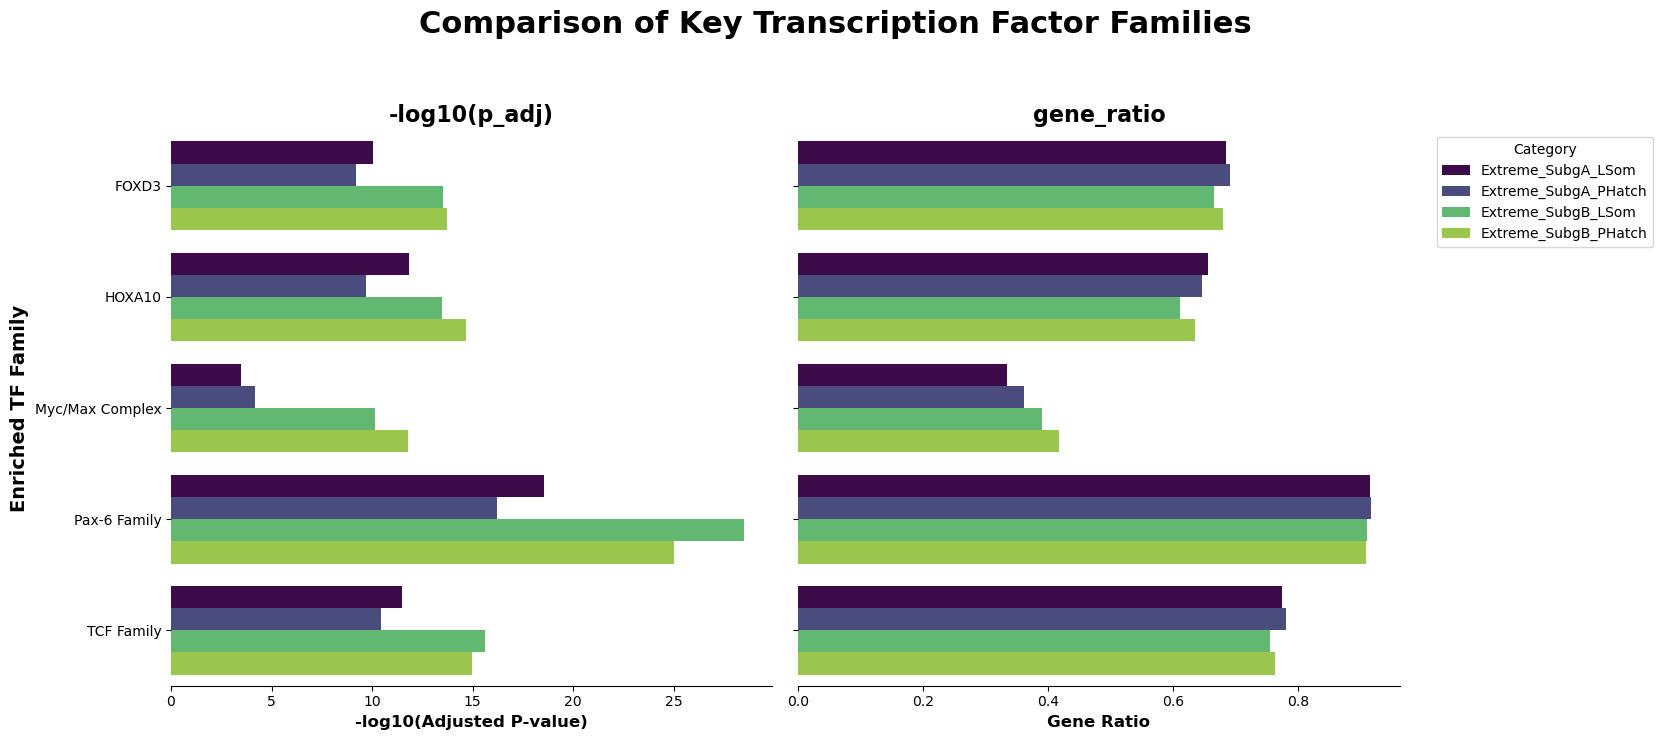

In [35]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


GPROFILER_RESULTS_DIR = 'gprofiler_results'

FILES_TO_PLOT = [
          'Extreme_SubgA_Dom_LSom__intersections.csv',
    'Extreme_SubgA_Dom_PHatch_intersections.csv',
    'Extreme_SubgB_Dom_LSom__intersections.csv',
    'Extreme_SubgB_Dom_PHatch_intersections.csv',
   
]

KEY_TF_FAMILIES = [
    'Pax-6 Family',
    'TCF Family',
    'HOXA10',
    'FOXD3',
    'Myc/Max Complex'
]

TERMS_TO_EXCLUDE = ['Transfac']



custom_palette = {
    'Extreme_SubgA_LSom': '#440154',    
    'Extreme_SubgA_PHatch': '#414487', 
    'Extreme_SubgB_LSom': '#55c667',    
    'Extreme_SubgB_PHatch': '#a0da39'   
}

def load_and_process_for_plot(directory, files_to_plot):
    all_results = []
    for filename in files_to_plot:

        category_name = filename.replace('gProfiler_', '').replace('.csv', '') \
                                .replace('_Dom', '').replace('_intersections', '').strip('_')
        filepath = os.path.join(directory, filename)
        if not os.path.exists(filepath): continue
        df = pd.read_csv(filepath, comment='#')
        df_tf = df[df['source'] == 'TF'].copy()
        if df_tf.empty: continue
        
        df_tf['gene_ratio'] = df_tf['intersection_size'] / df_tf['query_size']
        df_tf['adjusted_p_value'] = df_tf['adjusted_p_value'].replace(0, 1e-323)
        df_tf['-log10(p_adj)'] = -np.log10(df_tf['adjusted_p_value'])
        df_tf['category'] = category_name
        all_results.append(df_tf)
        
    if not all_results: return pd.DataFrame()
    return pd.concat(all_results, ignore_index=True)

print("--- Loading TF data for final presentation plot... ---")
df_all_tf_results = load_and_process_for_plot(GPROFILER_RESULTS_DIR, FILES_TO_PLOT)

if not df_all_tf_results.empty:
    df_filtered = df_all_tf_results[~df_all_tf_results['term_name'].isin(TERMS_TO_EXCLUDE)].copy()

    def simplify_tf_name(name):
        name_lower = name.lower()
        if 'myc' in name_lower or 'max' in name_lower: return 'Myc/Max Complex'
        if 'pax-6' in name_lower: return 'Pax-6 Family'
        if 'tcf-7' in name_lower or 'tcf-3' in name_lower: return 'TCF Family'
        if 'hoxa10' in name_lower: return 'HOXA10'
        if 'foxd3' in name_lower: return 'FOXD3'
        return 'Other'
    
    df_filtered['tf_family'] = df_filtered['term_name'].apply(simplify_tf_name)
    
    df_plot_data = df_filtered[df_filtered['tf_family'].isin(KEY_TF_FAMILIES)].copy()

    df_plot_data_agg = df_plot_data.groupby(['tf_family', 'category']).agg(
        **{'-log10(p_adj)': ('-log10(p_adj)', 'max'), 'gene_ratio': ('gene_ratio', 'max')}
    ).reset_index()

if 'df_plot_data_agg' in locals() and not df_plot_data_agg.empty:
    print("--- Generating final presentation-quality plot... ---")
    
    category_order = [cat.replace('gProfiler_', '').replace('.csv', '').replace('_Dom', '').replace('_intersections', '').strip('_') for cat in FILES_TO_PLOT]
    
    df_plot_data_agg['category'] = pd.Categorical(df_plot_data_agg['category'], categories=category_order, ordered=True)
    
    df_melted = pd.melt(df_plot_data_agg, id_vars=['tf_family', 'category'], value_vars=['-log10(p_adj)', 'gene_ratio'],
                        var_name='Metric', value_name='Value')

    g = sns.catplot(
        data=df_melted,
        x='Value',
        y='tf_family',
        hue='category',
        col='Metric',
        kind='bar',
        height=7,
        aspect=1.2,
        palette=custom_palette, 
        sharex=False,
        legend=False
    )

    g.fig.suptitle('Comparison of Key Transcription Factor Families', fontsize=22, weight='bold', y=1.05)
    g.set_axis_labels("Metric Value", "Enriched TF Family", size=14, weight='bold')
    g.set_titles("{col_name}", size=16, weight='bold')
    g.despine(left=True)

    g.axes[0,0].set_xlabel('-log10(Adjusted P-value)', size=12)
    g.axes[0,1].set_xlabel('Gene Ratio', size=12)
 
    plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    
    output_filename = 'final_presentation_tf_plot.png'
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    
    print(f"--- Final plot saved successfully as '{output_filename}' ---")
    plt.show()
else:
    print("Could not generate final plot because no key TFs were found after filtering.")

In [37]:
import os
import pandas as pd
import numpy as np


GPROFILER_RESULTS_DIR = 'gprofiler_results'
TERMS_TO_EXCLUDE = ['Metabolic pathways', 'KEGG root term']

def load_and_process_pathway_data(directory):
    
    """
    Loads all g:Profiler results, filters for KEGG pathways, and calculates an
    importance score for each entry.
    """
    all_pathway_results = []
 
    if not os.path.exists(directory):
        print(f"Error: Directory '{directory}' not found.")
        return pd.DataFrame()

    files_to_process = [f for f in os.listdir(directory) if f.endswith('.csv')]
    if not files_to_process:
        print(f"Error: No .csv files found in '{directory}'.")
        return pd.DataFrame()

    for filename in files_to_process:
        category_name = filename.replace('gProfiler_', '').replace('.csv', '') \
                                .replace('_intersections', '')
        
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath, comment='#')
 
        df_pathway = df[df['source'] == 'KEGG'].copy()
        
        if df_pathway.empty:
            continue
            

        df_pathway['gene_ratio'] = df_pathway['intersection_size'] / df_pathway['query_size']
        df_pathway['adjusted_p_value'] = df_pathway['adjusted_p_value'].replace(0, 1e-323)
        df_pathway['-log10(p_adj)'] = -np.log10(df_pathway['adjusted_p_value'])
        
        df_pathway['importance_score'] = df_pathway['-log10(p_adj)'] * df_pathway['gene_ratio']
        
        df_pathway['category'] = category_name
        all_pathway_results.append(df_pathway)
        
    if not all_pathway_results:
        print("No KEGG pathway enrichment results found in any of the files.")
        return pd.DataFrame()

    return pd.concat(all_pathway_results, ignore_index=True)

def rank_pathways(df):
    """
    Ranks pathways by their maximum importance score.
    """
    df_filtered = df[~df['term_name'].isin(TERMS_TO_EXCLUDE)].copy()

    ranking = df_filtered.groupby('term_name')['importance_score'].max()

    ranked_pathways = ranking.sort_values(ascending=False)
    
    return ranked_pathways

print("--- Starting KEGG Pathway Discovery and Ranking Analysis ---")
df_all_pathways = load_and_process_pathway_data(GPROFILER_RESULTS_DIR)

if not df_all_pathways.empty:
    ranked_pathway_list = rank_pathways(df_all_pathways)
    
    print("\n--- TOP 20 MOST IMPORTANT KEGG PATHWAYS ---")
    print("      (Ranked by max Importance Score across all samples)")
    print("----------------------------------------------------------")
    print(ranked_pathway_list.head(20).to_string())
    print("\n--- Analysis Complete ---")
    print("Please review this ranked list to select the final 'Key Pathways' for our visualization.")
else:
    print("Analysis could not be completed.")


--- Starting KEGG Pathway Discovery and Ranking Analysis ---

--- TOP 20 MOST IMPORTANT KEGG PATHWAYS ---
      (Ranked by max Importance Score across all samples)
----------------------------------------------------------
term_name
Endocytosis                                    0.408746
Protein processing in endoplasmic reticulum    0.287426
Salmonella infection                           0.246413
Regulation of actin cytoskeleton               0.218874
Mitophagy - animal                             0.161854
Autophagy - animal                             0.130583
ECM-receptor interaction                       0.124253
Cell cycle                                     0.115833
Wnt signaling pathway                          0.114396
Ribosome                                       0.113918
Focal adhesion                                 0.100716
Ribosome biogenesis in eukaryotes              0.096119
ATP-dependent chromatin remodeling             0.094942
FoxO signaling pathway                 

In [41]:
import os
import pandas as pd
import numpy as np

# --- 1. SETUP: FOCUSED ANALYSIS ON 'EXTREME' CATEGORIES ---

GPROFILER_RESULTS_DIR = 'gprofiler_results'

# --- EDIT: We now ONLY process the 'Extreme' bias result files ---
FILES_TO_PROCESS = [
    'Extreme_SubgA_Dom_LSom__intersections.csv',
    'Extreme_SubgA_Dom_PHatch_intersections.csv',
    'Extreme_SubgB_Dom_LSom__intersections.csv',
    'Extreme_SubgB_Dom_PHatch_intersections.csv',
]

# List of generic parent terms to EXCLUDE.
TERMS_TO_EXCLUDE = ['Metabolic pathways', 'KEGG root term', 'Salmonella infection']


# --- 2. DATA LOADING AND PREPARATION ---
def load_and_process_pathway_data(directory, files_to_process):
    """
    Loads specified g:Profiler results, filters for KEGG pathways, and calculates
    an importance score for each entry.
    """
    all_pathway_results = []
    
    if not os.path.exists(directory):
        print(f"Error: Directory '{directory}' not found.")
        return pd.DataFrame()

    for filename in files_to_process:
        filepath = os.path.join(directory, filename)
        if not os.path.exists(filepath):
            print(f"Warning: File not found, skipping: {filename}")
            continue

        category_name = filename.replace('gProfiler_', '').replace('.csv', '') \
                                .replace('_intersections', '')
        
        df = pd.read_csv(filepath, comment='#')
        
        # Filter for KEGG pathway results only
        df_pathway = df[df['source'] == 'KEGG'].copy()
        
        if df_pathway.empty:
            continue
            
        # Calculate Gene Ratio and -log10(p-value)
        df_pathway['gene_ratio'] = df_pathway['intersection_size'] / df_pathway['query_size']
        df_pathway['adjusted_p_value'] = df_pathway['adjusted_p_value'].replace(0, 1e-323)
        df_pathway['-log10(p_adj)'] = -np.log10(df_pathway['adjusted_p_value'])
        
        # --- Calculate the Importance Score ---
        df_pathway['importance_score'] = df_pathway['-log10(p_adj)'] * df_pathway['gene_ratio']
        
        df_pathway['category'] = category_name
        all_pathway_results.append(df_pathway)
        
    if not all_pathway_results:
        print("No KEGG pathway enrichment results found in the specified files.")
        return pd.DataFrame()

    return pd.concat(all_pathway_results, ignore_index=True)


# --- 3. RANKING PATHWAYS ---
def rank_pathways(df):
    """
    Ranks pathways by their maximum importance score.
    """
    # First, filter out generic terms
    df_filtered = df[~df['term_name'].isin(TERMS_TO_EXCLUDE)].copy()
    
    # For each pathway, find its single highest importance score
    ranking = df_filtered.groupby('term_name')['importance_score'].max()
    
    # Sort the pathways by this max importance score
    ranked_pathways = ranking.sort_values(ascending=False)
    
    return ranked_pathways


# --- 4. EXECUTION ---
print("--- Starting KEGG Pathway Discovery and Ranking (Extreme Bias Only) ---")
df_extreme_pathways = load_and_process_pathway_data(GPROFILER_RESULTS_DIR, FILES_TO_PROCESS)

if not df_extreme_pathways.empty:
    ranked_pathway_list = rank_pathways(df_extreme_pathways)
    
    print("\n--- TOP 20 MOST IMPORTANT KEGG PATHWAYS (from Extreme Bias sets) ---")
    print("      (Ranked by max Importance Score across the 4 Extreme samples)")
    print("--------------------------------------------------------------------")
    print(ranked_pathway_list.head(20).to_string())
    print("\n--- Analysis Complete ---")
    print("Please review this new ranked list to confirm our selection of 'Key Pathways'.")
else:
    print("Analysis could not be completed.")



--- Starting KEGG Pathway Discovery and Ranking (Extreme Bias Only) ---

--- TOP 20 MOST IMPORTANT KEGG PATHWAYS (from Extreme Bias sets) ---
      (Ranked by max Importance Score across the 4 Extreme samples)
--------------------------------------------------------------------
term_name
ECM-receptor interaction                      0.124253
Ribosome biogenesis in eukaryotes             0.096119
Biosynthesis of cofactors                     0.081219
Glycine, serine and threonine metabolism      0.077065
Carbon metabolism                             0.072710
Lysosome                                      0.067473
Focal adhesion                                0.064840
Biosynthesis of amino acids                   0.056915
Sphingolipid metabolism                       0.051500
Porphyrin metabolism                          0.041399
Glyoxylate and dicarboxylate metabolism       0.041200
Valine, leucine and isoleucine degradation    0.039227
Phagosome                                     0.036

In [47]:
import os
import pandas as pd
import numpy as np


GPROFILER_RESULTS_DIR = 'gprofiler_results'

FILES_TO_PROCESS = [
    'Extreme_SubgA_Dom_LSom__intersections.csv',
    'Extreme_SubgA_Dom_PHatch_intersections.csv',
    'Extreme_SubgB_Dom_LSom__intersections.csv',
    'Extreme_SubgB_Dom_PHatch_intersections.csv',
]

TERMS_TO_EXCLUDE = ['Transfac']

def load_and_process_tf_data(directory, files_to_process):
    """
    Loads specified g:Profiler results, filters for TFs, and calculates an
    importance score for each entry.
    """
    all_tf_results = []
    
    if not os.path.exists(directory):
        print(f"Error: Directory '{directory}' not found.")
        return pd.DataFrame()

    for filename in files_to_process:
        filepath = os.path.join(directory, filename)
        if not os.path.exists(filepath):
            print(f"Warning: File not found, skipping: {filename}")
            continue

        category_name = filename.replace('gProfiler_', '').replace('.csv', '') \
                                .replace('_intersections', '')
        
        df = pd.read_csv(filepath, comment='#')
  
        df_tf = df[df['source'] == 'TF'].copy()
        
        if df_tf.empty:
            continue

        df_tf['gene_ratio'] = df_tf['intersection_size'] / df_tf['query_size']
        df_tf['adjusted_p_value'] = df_tf['adjusted_p_value'].replace(0, 1e-323)
        df_tf['-log10(p_adj)'] = -np.log10(df_tf['adjusted_p_value'])

        df_tf['importance_score'] = df_tf['-log10(p_adj)'] * df_tf['gene_ratio']
        
        df_tf['category'] = category_name
        all_tf_results.append(df_tf)
        
    if not all_tf_results:
        print("No TF enrichment results found in the specified files.")
        return pd.DataFrame()

    return pd.concat(all_tf_results, ignore_index=True)

def rank_tfs(df):
    """
    Groups related TFs and ranks them by their maximum importance score.
    """

    df_filtered = df[~df['term_name'].isin(TERMS_TO_EXCLUDE)].copy()

    def simplify_tf_name(name):
        name_lower = name.lower()

        if 'myc' in name_lower or 'max' in name_lower: return 'Myc/Max Complex'
        if 'pax-6' in name_lower: return 'Pax-6 Family'
        if 'pax-5' in name_lower: return 'Pax-5 Family'
        if 'pax-8' in name_lower: return 'Pax-8 Family'
        if 'tcf-7' in name_lower or 'tcf-3' in name_lower: return 'TCF Family'
        if 'hoxa10' in name_lower: return 'HOXA10'
        if 'foxd3' in name_lower: return 'FOXD3'
        if 'meis1' in name_lower: return 'MEIS1 Family'
        return name.split(';')[0] 

    df_filtered['tf_family'] = df_filtered['term_name'].apply(simplify_tf_name)

    ranking = df_filtered.groupby('tf_family')['importance_score'].max()
 
    ranked_tfs = ranking.sort_values(ascending=False)
    
    return ranked_tfs

print("--- Starting TF Discovery and Ranking (Extreme Bias Only) ---")
df_extreme_tfs = load_and_process_tf_data(GPROFILER_RESULTS_DIR, FILES_TO_PROCESS)

if not df_extreme_tfs.empty:
    ranked_tf_list = rank_tfs(df_extreme_tfs)
    
    print("\n--- TOP 20 MOST IMPORTANT TF FAMILIES (from Extreme Bias sets) ---")
    print("      (Ranked by max Importance Score across the 4 Extreme samples)")
    print("--------------------------------------------------------------------")
    print(ranked_tf_list.head(20).to_string())
    print("\n--- Analysis Complete ---")
    print("Please compare this ranked list to the previous one to confirm our selection.")
else:
    print("Analysis could not be completed.")


--- Starting TF Discovery and Ranking (Extreme Bias Only) ---

--- TOP 20 MOST IMPORTANT TF FAMILIES (from Extreme Bias sets) ---
      (Ranked by max Importance Score across the 4 Extreme samples)
--------------------------------------------------------------------
tf_family
Pax-6 Family         25.902920
MEIS1 Family         16.695453
TCF Family           11.790730
FOXD3                 9.329959
HOXA10                9.296912
Factor: FOX           7.964530
Pax-8 Family          7.392756
Factor: HNF3A         5.886203
Factor: Freac-4       5.176729
Myc/Max Complex       4.930474
Factor: HNF3          4.889116
Factor: PEA3          3.724280
Factor: HNF3alpha     3.473546
Factor: HOX           3.373143
Factor: ARNTLIKE      2.352255
Factor: MAF           2.127062
Factor: SMAD          1.933151
Pax-5 Family          1.700582
Factor: Fli-1         1.595629
Factor: LEF-1         1.576594

--- Analysis Complete ---
Please compare this ranked list to the previous one to confirm our selection

In [7]:
import os
import pandas as pd
import numpy as np


GPROFILER_RESULTS_DIR = 'gprofiler_results'


FILES_TO_PROCESS = [
     'Extreme_SubgA_Dom_LSom__intersections.csv',
    'Extreme_SubgA_Dom_PHatch_intersections.csv',
    'Extreme_SubgB_Dom_LSom__intersections.csv',
    'Extreme_SubgB_Dom_PHatch_intersections.csv',
]

TERMS_TO_EXCLUDE = ['Metabolic pathways', 'KEGG root term', 'Salmonella infection']


print("--- Generating Ranked Pathway Lists for Each Category ---")

for filename in FILES_TO_PROCESS:
    filepath = os.path.join(GPROFILER_RESULTS_DIR, filename)
    

    if not os.path.exists(filepath):
        print(f"\n--- WARNING: File not found, skipping: {filename} ---")
        continue

    df_full = pd.read_csv(filepath, comment='#')
    
    df_kegg = df_full[df_full['source'] == 'KEGG'].copy()
    
    if df_kegg.empty:
        category_name_header = filename.replace('gProfiler_', '').replace('.csv', '').replace('_intersections', '')
        print(f"\n--- Top 10 KEGG Pathways for: {category_name_header} ---")
        print("    (No significant KEGG pathways found for this category)")
        continue

 
    df_kegg = df_kegg[~df_kegg['term_name'].isin(TERMS_TO_EXCLUDE)]
    
    df_kegg['gene_ratio'] = df_kegg['intersection_size'] / df_kegg['query_size']
    df_kegg['adjusted_p_value'] = df_kegg['adjusted_p_value'].replace(0, 1e-323)
    df_kegg['-log10(p_adj)'] = -np.log10(df_kegg['adjusted_p_value'])
 
    df_kegg['importance_score'] = df_kegg['-log10(p_adj)'] * df_kegg['gene_ratio']
    
    df_ranked = df_kegg.sort_values('importance_score', ascending=False)

    category_name_header = filename.replace('gProfiler_', '').replace('.csv', '').replace('_intersections', '')
    
    print(f"\n\n--- Top 10 KEGG Pathways for: {category_name_header} ---")
    print("----------------------------------------------------------" + "-" * len(category_name_header))
    
    table_data = df_ranked[['term_name', 'importance_score', 'adjusted_p_value', 'gene_ratio']]
    
    print(table_data.head(10).to_string(index=False))

print("\n\n--- Analysis Complete ---")


--- Generating Ranked Pathway Lists for Each Category ---


--- Top 10 KEGG Pathways for: Extreme_SubgA_Dom_LSom_ ---
---------------------------------------------------------------------------------
                        term_name  importance_score  adjusted_p_value  gene_ratio
Ribosome biogenesis in eukaryotes          0.096119          0.000396    0.028249
          Glycerolipid metabolism          0.022347          0.048029    0.016949


--- Top 10 KEGG Pathways for: Extreme_SubgA_Dom_PHatch ---
----------------------------------------------------------------------------------
            term_name  importance_score  adjusted_p_value  gene_ratio
Pyrimidine metabolism           0.02671          0.041686    0.019355


--- Top 10 KEGG Pathways for: Extreme_SubgB_Dom_LSom_ ---
---------------------------------------------------------------------------------
                                 term_name  importance_score  adjusted_p_value  gene_ratio
                                  Lys

--- Processed pathway data for each category. ---
--- Created master lists: 3 terms for SubgA row, 10 terms for SubgB row. ---


/var/folders/bp/612g8dnd7hv531z_7pdvjlkr0000gn/T/ipykernel_4146/1328715439.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['term_name'] = pd.Categorical(plot_data['term_name'], categories=master_list_subb, ordered=True)
/var/folders/bp/612g8dnd7hv531z_7pdvjlkr0000gn/T/ipykernel_4146/1328715439.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['term_name'] = pd.Categorical(plot_data['term_name'], categories=master_list_subb, ordered=True)


--- Final figure saved successfully as 'final_pathway_summary_figure.png' ---


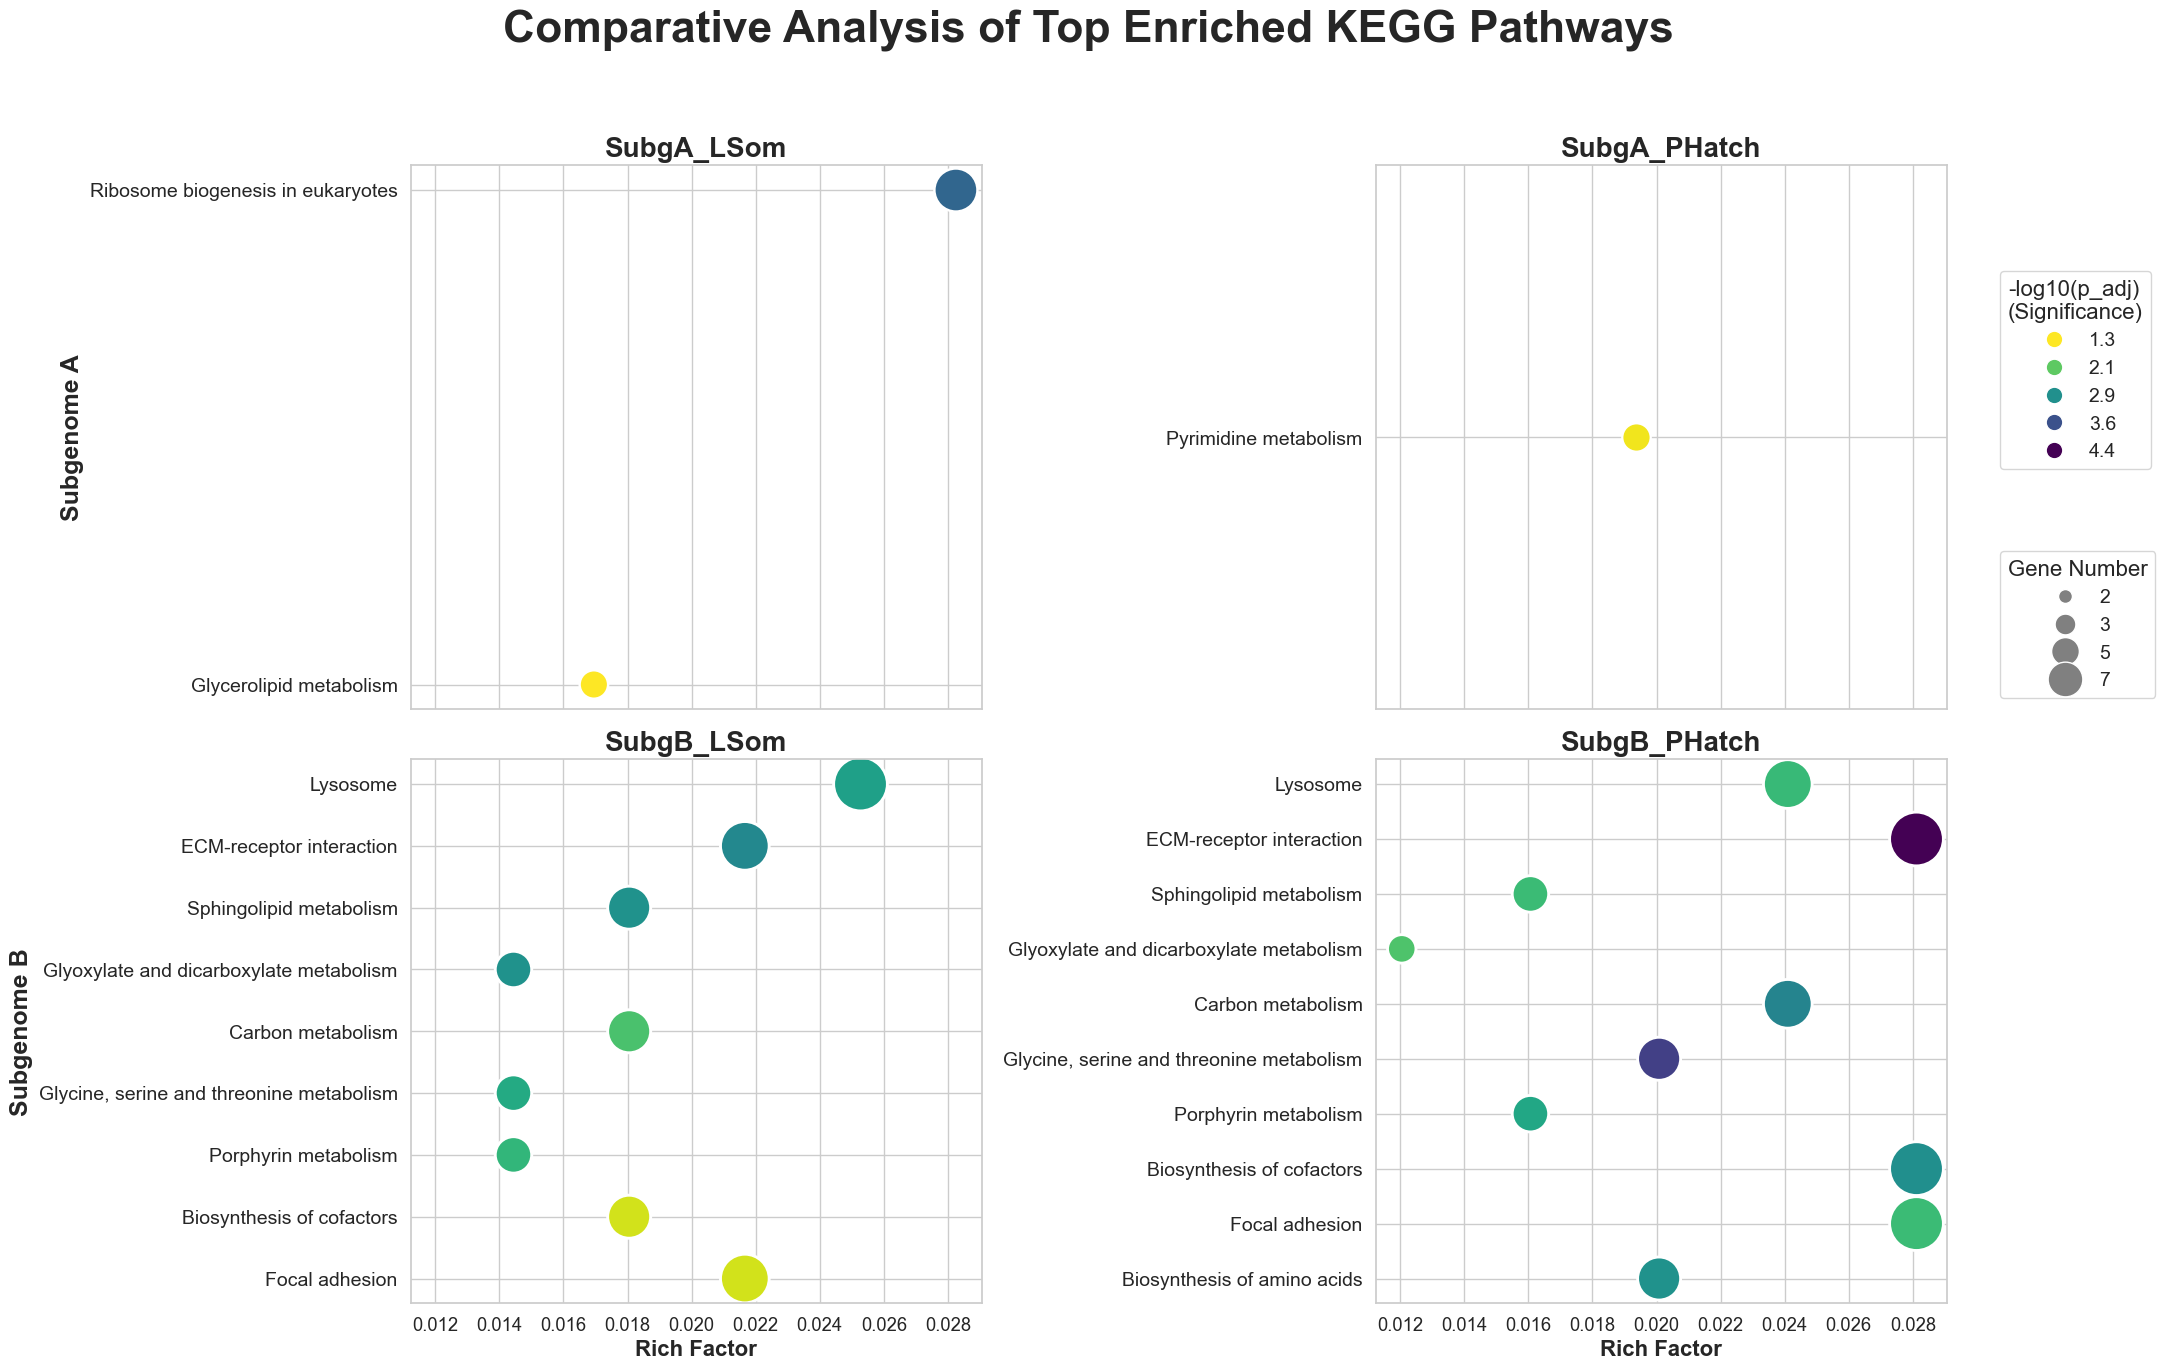

In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D


GPROFILER_RESULTS_DIR = 'gprofiler_results'
OUTPUT_FILENAME = 'final_pathway_summary_figure.png'

SUBA_FILES = ['Extreme_SubgA_Dom_LSom__intersections.csv',
    'Extreme_SubgA_Dom_PHatch_intersections.csv']
SUBB_FILES = [ 'Extreme_SubgB_Dom_LSom__intersections.csv',
    'Extreme_SubgB_Dom_PHatch_intersections.csv']

TERMS_TO_EXCLUDE = ['Metabolic pathways', 'KEGG root term', 'Salmonella infection']


def get_pathway_data(filepath):
    """Loads and processes a single g:Profiler file."""
    if not os.path.exists(filepath): return pd.DataFrame()
    df = pd.read_csv(filepath, comment='#')
    df_kegg = df[df['source'] == 'KEGG'].copy()
    if df_kegg.empty: return pd.DataFrame()
    df_kegg = df_kegg[~df_kegg['term_name'].isin(TERMS_TO_EXCLUDE)]
    if df_kegg.empty: return pd.DataFrame()
        
    df_kegg['gene_ratio'] = df_kegg['intersection_size'] / df_kegg['query_size']
    df_kegg['adjusted_p_value'] = df_kegg['adjusted_p_value'].replace(0, 1e-323)
    df_kegg['-log10(p_adj)'] = -np.log10(df_kegg['adjusted_p_value'])
    df_kegg['importance_score'] = df_kegg['-log10(p_adj)'] * df_kegg['gene_ratio']
    
    return df_kegg

all_pathway_data = {}
for filename in SUBA_FILES + SUBB_FILES:
    category_name = filename.replace('gProfiler_', '').replace('.csv', '').replace('_intersections', '').strip('_')
    filepath = os.path.join(GPROFILER_RESULTS_DIR, filename)
    all_pathway_data[category_name] = get_pathway_data(filepath)

print("--- Processed pathway data for each category. ---")


def get_master_list(data_dict, file_list):
    top_terms = []
    for filename in file_list:
        category_name = filename.replace('gProfiler_', '').replace('.csv', '').replace('_intersections', '').strip('_')
        if category_name in data_dict and not data_dict[category_name].empty:
            top_terms.append(data_dict[category_name].sort_values('importance_score', ascending=False).head(7)['term_name'])
    if not top_terms: return []
    master_df = pd.concat(top_terms).drop_duplicates().reset_index(drop=True)
    return master_df.tolist()

master_list_suba = get_master_list(all_pathway_data, SUBA_FILES)
master_list_subb = get_master_list(all_pathway_data, SUBB_FILES)

print(f"--- Created master lists: {len(master_list_suba)} terms for SubgA row, {len(master_list_subb)} terms for SubgB row. ---")


sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(22, 14), sharex=True)
fig.suptitle('Comparative Analysis of Top Enriched KEGG Pathways', fontsize=32, weight='bold')

all_data_df = pd.concat(all_pathway_data.values())
if not all_data_df.empty:
    hue_norm = plt.Normalize(all_data_df['-log10(p_adj)'].min(), all_data_df['-log10(p_adj)'].max())
    size_norm = plt.Normalize(all_data_df['intersection_size'].min(), all_data_df['intersection_size'].max())
else:
    hue_norm, size_norm = plt.Normalize(0,1), plt.Normalize(0,1)

for i, filename in enumerate(SUBA_FILES):
    ax = axes[0, i]
    category_name = filename.replace('gProfiler_', '').replace('.csv', '').replace('_intersections', '').strip('_')
    data = all_pathway_data[category_name]
    
    ax.set_title(category_name.replace('Extreme_', '').replace('_Dom', ''), fontsize=20, weight='bold')
    
    if not data.empty and master_list_suba:
        plot_data = data[data['term_name'].isin(master_list_suba)]
        # Set the y-axis order to our master list
        plot_data['term_name'] = pd.Categorical(plot_data['term_name'], categories=master_list_suba, ordered=True)
        sns.scatterplot(x='gene_ratio', y='term_name', data=plot_data, size='intersection_size', hue='-log10(p_adj)',
                        palette='viridis_r', sizes=(150, 1500), hue_norm=hue_norm, size_norm=size_norm, ax=ax, legend=False)
    ax.set_ylabel('')
    ax.tick_params(axis='y', labelsize=14)
    if i == 0: ax.set_ylabel('Subgenome A', fontsize=18, weight='bold')

for i, filename in enumerate(SUBB_FILES):
    ax = axes[1, i]
    category_name = filename.replace('gProfiler_', '').replace('.csv', '').replace('_intersections', '').strip('_')
    data = all_pathway_data[category_name]
    
    ax.set_title(category_name.replace('Extreme_', '').replace('_Dom', ''), fontsize=20, weight='bold')

    if not data.empty and master_list_subb:
        plot_data = data[data['term_name'].isin(master_list_subb)]
        plot_data['term_name'] = pd.Categorical(plot_data['term_name'], categories=master_list_subb, ordered=True)
        sns.scatterplot(x='gene_ratio', y='term_name', data=plot_data, size='intersection_size', hue='-log10(p_adj)',
                        palette='viridis_r', sizes=(150, 1500), hue_norm=hue_norm, size_norm=size_norm, ax=ax, legend=False)
    ax.set_xlabel('Rich Factor', fontsize=16, weight='bold')
    ax.set_ylabel('')
    ax.tick_params(axis='y', labelsize=14)
    if i == 0: ax.set_ylabel('Subgenome B', fontsize=18, weight='bold')


cmap = plt.get_cmap('viridis_r')
p_val_handles = [Line2D([0], [0], marker='o', color='w', label=f'{val:.1f}', markerfacecolor=cmap(hue_norm(val)), markersize=12) for val in np.linspace(hue_norm.vmin, hue_norm.vmax, 5)]
size_handles = [Line2D([0], [0], marker='o', color='w', label=f'{int(val)}', markerfacecolor='grey', markersize=np.interp(val, [size_norm.vmin, size_norm.vmax], [10, 25])) for val in np.linspace(size_norm.vmin, size_norm.vmax, 4)]
legend1 = fig.legend(handles=p_val_handles, title='-log10(p_adj)\n(Significance)', bbox_to_anchor=(0.91, 0.8), loc='upper left', title_fontsize='16', fontsize='14')
legend2 = fig.legend(handles=size_handles, title='Gene Number', bbox_to_anchor=(0.91, 0.6), loc='upper left', title_fontsize='16', fontsize='14')

fig.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.savefig(OUTPUT_FILENAME, dpi=300, bbox_inches='tight')
print(f"--- Final figure saved successfully as '{OUTPUT_FILENAME}' ---")
plt.show()



In [1]:
import os
import pandas as pd
import numpy as np

OHNOLOG_SET_PATH = 'filtered_ohnologs_7497_basemean150.csv' 

MAPPING_FILE_PATH = 'Zebrafish_mapping.tsv'

CARP_ID_A_COL = 'geneID_sgA'
CARP_ID_B_COL = 'geneID_sgB'
MAPPING_CARP_ID_COL = 'Common carp gene stable ID'
MAPPING_CONFIDENCE_COL = 'Common carp orthology confidence [0 low, 1 high]'
MAPPING_HOMOLOGY_TYPE_COL = 'Common carp homology type'

print("--- Loading data... ---")
try:
    df_ohnologs = pd.read_csv(OHNOLOG_SET_PATH)
    df_map = pd.read_csv(MAPPING_FILE_PATH, sep='\t')
    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"CRITICAL ERROR: Could not find a required file. {e}")
    exit()

print("\n--- Performing Mapping Analysis ---")

ids_a = set(df_ohnologs[CARP_ID_A_COL].dropna())
ids_b = set(df_ohnologs[CARP_ID_B_COL].dropna())
total_unique_carp_ids_in_dataset = ids_a.union(ids_b)
num_total_unique_carp_ids = len(total_unique_carp_ids_in_dataset)

df_map_high_conf = df_map[df_map[MAPPING_CONFIDENCE_COL] == 1.0]

mappable_carp_ids = set(df_map_high_conf[MAPPING_CARP_ID_COL].dropna())

successfully_mapped_ids = total_unique_carp_ids_in_dataset.intersection(mappable_carp_ids)
num_successfully_mapped = len(successfully_mapped_ids)

unmapped_ids = total_unique_carp_ids_in_dataset - successfully_mapped_ids
num_unmapped = len(unmapped_ids)

mapping_percentage = (num_successfully_mapped / num_total_unique_carp_ids) * 100 if num_total_unique_carp_ids > 0 else 0

mapped_homology_types = df_map_high_conf[
    df_map_high_conf[MAPPING_CARP_ID_COL].isin(successfully_mapped_ids)
][MAPPING_HOMOLOGY_TYPE_COL].value_counts()


print("\n\n--- ORTHOLOGY MAPPING STATISTICAL REPORT ---")
print("============================================")
print("\n1. Mapping Success Rate:")
print(f"   - Total unique carp gene IDs in dataset: {num_total_unique_carp_ids}")
print(f"   - Number of those IDs with a high-confidence ortholog: {num_successfully_mapped}")
print(f"   - Number of unmapped IDs: {num_unmapped}")
print(f"   - Overall Mapping Success Rate: {mapping_percentage:.2f}%")

print("\n2. Characterization of Mapped Homology Types (for successfully mapped genes):")
print("   (This shows the prevalence of different orthology relationships)")
print(mapped_homology_types.to_string())

print("\n3. Characterization of Unmapped Genes:")
print(f"   - A total of {num_unmapped} unique carp gene IDs from the dataset did not have a high-confidence")
print("     ortholog in the Ensembl mapping file. This is an expected result in cross-species")
print("     analysis and may be due to several factors:")
print("       - Lineage-specific genes that evolved in the carp lineage after divergence from zebrafish.")
print("       - Incomplete or provisional gene annotations in the current carp genome assembly.")
print("       - Genes whose orthologous relationship did not meet Ensembl's high-confidence threshold.")
print("\n   - A list of the first 20 unmapped IDs (for spot-checking):")
print(f"     {list(unmapped_ids)[:20]}")

print("\n============================================")
print("--- Report Complete ---")


--- Loading data... ---
Data loaded successfully.

--- Performing Mapping Analysis ---


--- ORTHOLOGY MAPPING STATISTICAL REPORT ---

1. Mapping Success Rate:
   - Total unique carp gene IDs in dataset: 14994
   - Number of those IDs with a high-confidence ortholog: 11101
   - Number of unmapped IDs: 3893
   - Overall Mapping Success Rate: 74.04%

2. Characterization of Mapped Homology Types (for successfully mapped genes):
   (This shows the prevalence of different orthology relationships)
Common carp homology type
ortholog_one2many     11015
ortholog_many2many       52
ortholog_one2one         37

3. Characterization of Unmapped Genes:
   - A total of 3893 unique carp gene IDs from the dataset did not have a high-confidence
     ortholog in the Ensembl mapping file. This is an expected result in cross-species
     analysis and may be due to several factors:
       - Lineage-specific genes that evolved in the carp lineage after divergence from zebrafish.
       - Incomplete or provis